In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from object_loc_helper import get_VGG16_concat_dense, get_VGG16_concat, get_VGG16, GeneratorMultipleOutputs, get_simple_model, iou, PlotLosses, IOU_loss, get_concat_model, plot_batch

Using TensorFlow backend.


Intersection Over Union Paper
https://arxiv.org/pdf/1608.01471.pdf

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import matplotlib.patches as patches
from object_loc_helper import get_class_names_map, PlotLosses

In [4]:
data_folder = 'dataset/ILSVRC/Data/CLS-LOC'
reduced_dataset_folder = 'dataset_5_classes'

In [5]:
train_folder = reduced_dataset_folder + '/images/train'
val_folder = reduced_dataset_folder + '/images/val'

In [6]:
annotations_dict_train = np.load(reduced_dataset_folder+'/annotations_train.npy').flat[0]
annotations_dict_val = np.load(reduced_dataset_folder+'/annotations_val.npy').flat[0]

In [7]:
annotations_dict_train

{'n04487081': {'n04487081_216': {'width': 500,
   'height': 375,
   'depth': 3,
   'bounding_boxes': [[147, 34, 330, 274]]},
  'n04487081_7989': {'width': 500,
   'height': 375,
   'depth': 3,
   'bounding_boxes': [[105, 188, 431, 319]]},
  'n04487081_22715': {'width': 500,
   'height': 375,
   'depth': 3,
   'bounding_boxes': [[93, 167, 366, 360]]},
  'n04487081_14567': {'width': 500,
   'height': 375,
   'depth': 3,
   'bounding_boxes': [[263, 194, 380, 321]]},
  'n04487081_3973': {'width': 500,
   'height': 375,
   'depth': 3,
   'bounding_boxes': [[98, 2, 442, 318]]},
  'n04487081_258': {'width': 500,
   'height': 375,
   'depth': 3,
   'bounding_boxes': [[283, 154, 391, 254]]},
  'n04487081_9739': {'width': 500,
   'height': 375,
   'depth': 3,
   'bounding_boxes': [[219, 141, 332, 221]]},
  'n04487081_24494': {'width': 500,
   'height': 333,
   'depth': 3,
   'bounding_boxes': [[121, 167, 297, 269]]},
  'n04487081_14664': {'width': 500,
   'height': 375,
   'depth': 3,
   'boundi

In [7]:
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, val_folder, 50, flip = 'random', get_filenames=True)
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, train_folder, 64, flip = 'random')

Found 209 images belonging to 5 classes.
Found 3458 images belonging to 5 classes.


In [8]:
#batch = next(val_generator_multiple_outputs)

{'width': 500, 'height': 375, 'depth': 3, 'bounding_boxes': [[0, 74, 426, 360]]}


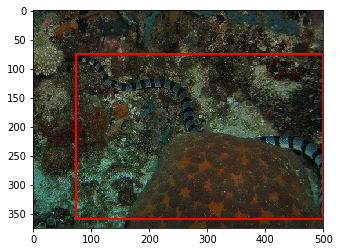

{'width': 500, 'height': 375, 'depth': 3, 'bounding_boxes': [[34, 56, 461, 319]]}


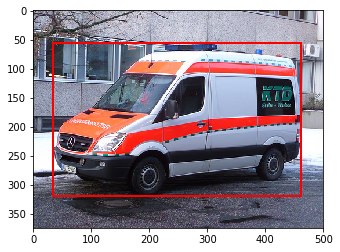

{'width': 500, 'height': 375, 'depth': 3, 'bounding_boxes': [[152, 132, 319, 244]]}


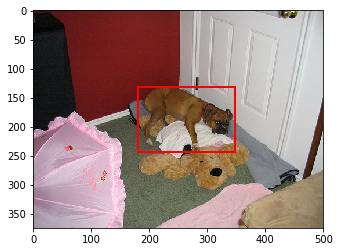

{'width': 500, 'height': 375, 'depth': 3, 'bounding_boxes': [[69, 146, 429, 293]]}


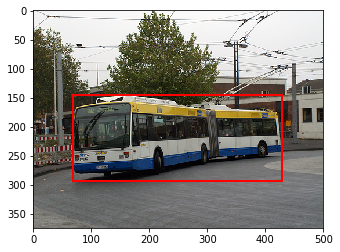

{'width': 500, 'height': 375, 'depth': 3, 'bounding_boxes': [[196, 61, 338, 373]]}


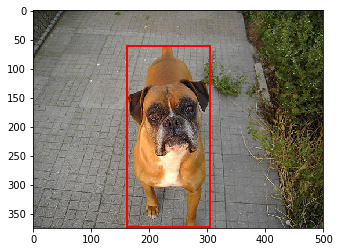

{'width': 500, 'height': 375, 'depth': 3, 'bounding_boxes': [[58, 79, 446, 306]]}


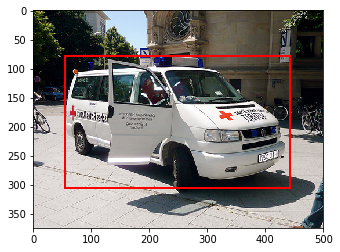

{'width': 500, 'height': 375, 'depth': 3, 'bounding_boxes': [[2, 121, 430, 311]]}


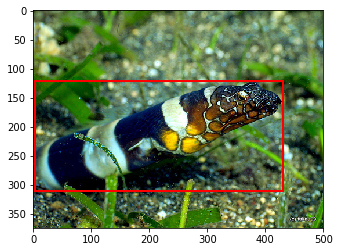

{'width': 500, 'height': 375, 'depth': 3, 'bounding_boxes': [[102, 147, 334, 231]]}


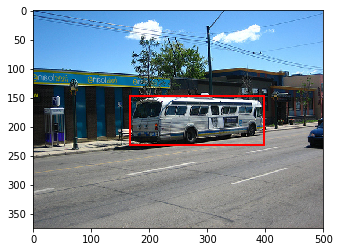

{'width': 500, 'height': 375, 'depth': 3, 'bounding_boxes': [[199, 12, 480, 362]]}


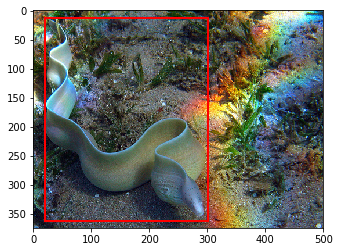

{'width': 500, 'height': 375, 'depth': 3, 'bounding_boxes': [[83, 196, 301, 287]]}


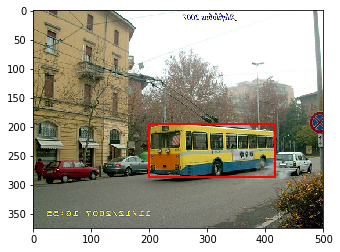

In [9]:
plot_batch(val_generator_multiple_outputs, count = 10)

In [37]:
n_classes=5
#model = get_simple_model(input_shape=(375, 500, 3), n_classes=n_classes, dropout_rate_1=0.1, dropout_rate_2=0.05)
#model = get_VGG16_concat(n_classes=n_classes, dropout_rate_1=0.5, dropout_rate_2=0.25, N_trainable=17)
model = get_VGG16_concat_dense()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 375, 500, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 375, 500, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 375, 500, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 187, 250, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [43]:
losses = {"category_output": "categorical_crossentropy", 
          #"bounding_box": "mean_squared_error"
          "bounding_box": IOU_loss
         }
metrics = {"category_output": "accuracy", 
           "bounding_box": [iou, "mae"]
          }
lossWeights = {"category_output": 1.0, 
               "bounding_box":  1.0,
              }

In [44]:
#5_classes_w_120_do_0.25_Adam_0.001_iou
#5_classes_w_120_do_0.25_Adam_0.0001
#model.load_weights('VGG-16.hdf5')

In [45]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, train_folder, 32, flip = 'random')
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, val_folder, 32, flip = 'random')

Found 3458 images belonging to 5 classes.
Found 209 images belonging to 5 classes.


In [46]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, rmsprop, SGD
filename = 'runtime'
checkpoint = ModelCheckpoint(filepath = filename+'_best.hdf5', 
                             monitor='val_category_output_acc', save_best_only=True)
model.compile(loss=losses,
              #optimizer=rmsprop(),
              optimizer=Adam(lr=0.001),
              metrics=metrics,
              loss_weights = lossWeights)

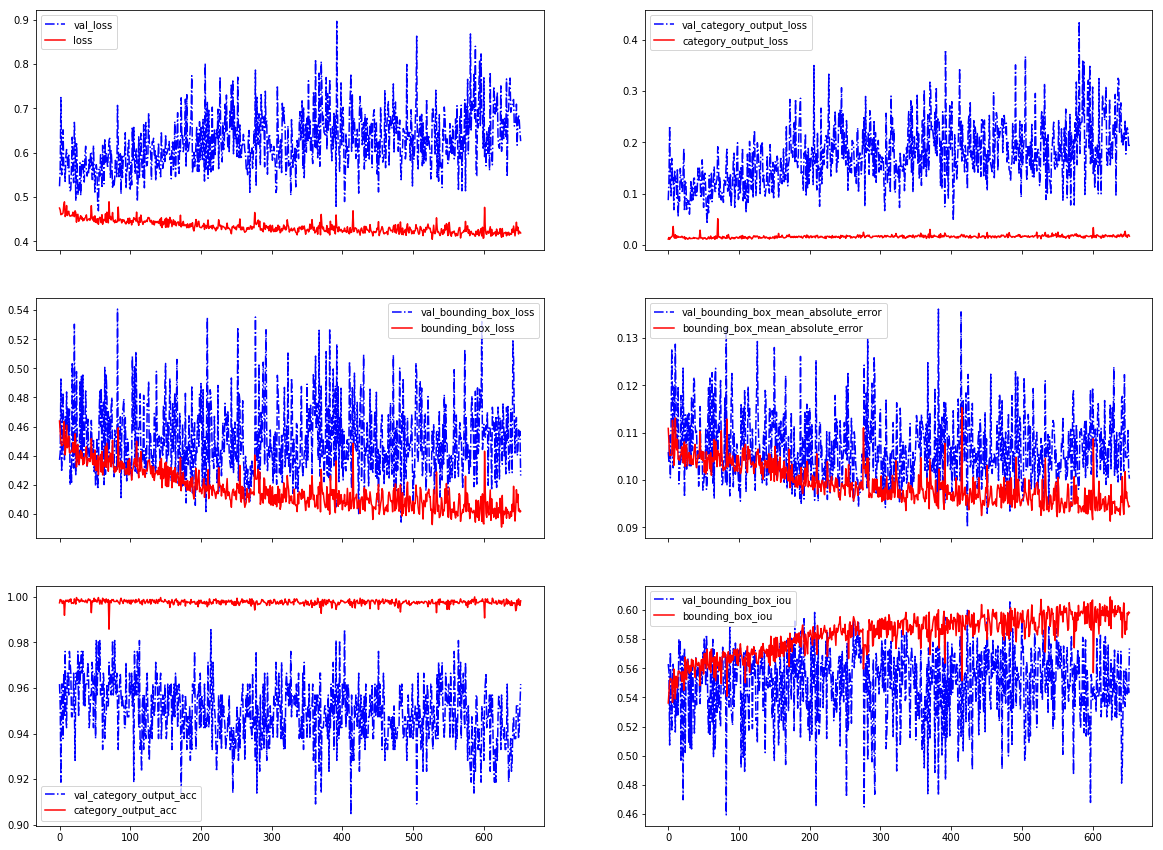

Epoch 654/2000
 73/109 [===================>..........] - ETA: 11s - loss: 0.4283 - category_output_loss: 0.0149 - bounding_box_loss: 0.4134 - category_output_acc: 0.9983 - bounding_box_iou: 0.5866 - bounding_box_mean_absolute_error: 0.0975

KeyboardInterrupt: 

In [47]:
plot_losses = PlotLosses(1)
model.fit_generator(
        train_generator_multiple_outputs,
        #steps_per_epoch=steps_per_epoch,
        epochs=2000,
        validation_data=val_generator_multiple_outputs, callbacks = [plot_losses, checkpoint]
        )

In [ ]:
model.evaluate_generator(val_generator_multiple_outputs)

In [12]:
model.evaluate_generator(train_generator_multiple_outputs)

[6.54080606299593,
 1.3182526528073089,
 0.043521278149560284,
 0.5063938615877001,
 0.378710380752983,
 0.1702160732749173]

In [13]:
model.save_weights(filename+'_last.hdf5')